<h1 align='center'> FORECASTING WITH DEEP LEARNING (PART II) </h1>

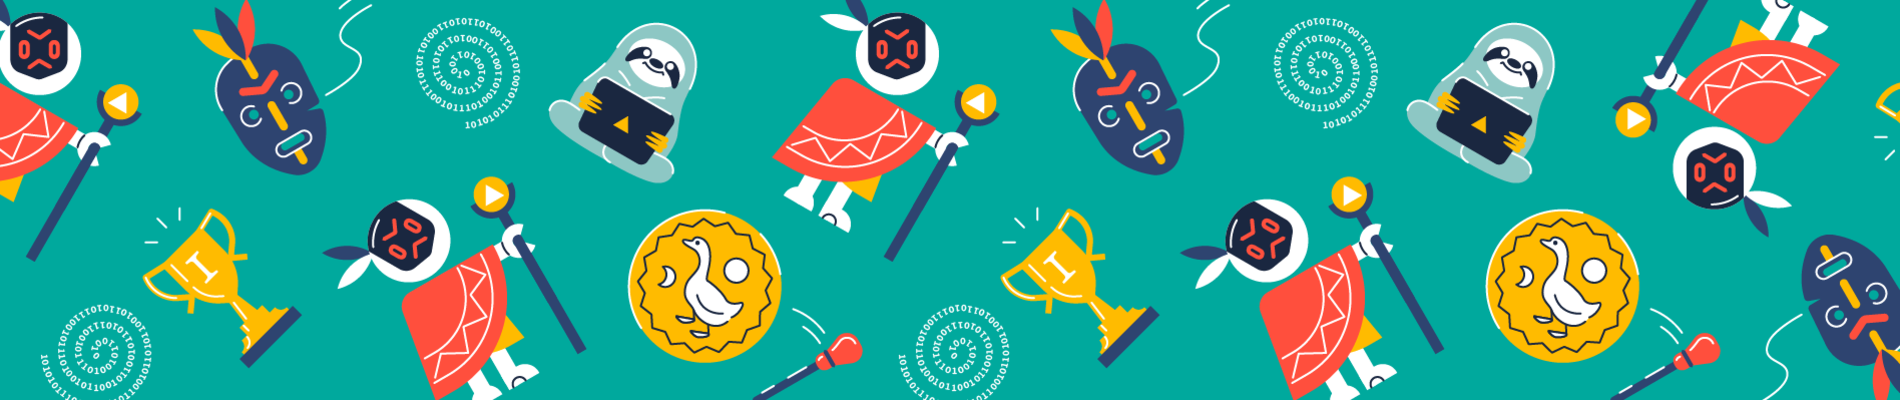

## Introduction

The first part of the forecasting with deep learning introduced varios deep learning networks that were aimed to forecast one step ahead of time with a data set that included a time series of 5 years of 50 product sales from 10 different stores. This time we will try to forecast multiple steps ahead of time, or one year in the future, with a data set of a time series from 5 years of product sales from one store. Because the task is now much more difficult than in the previous part, the data set is simpler, and we will create some additional features that will help with the forecasting challenge.

In [1805]:
# Importing libraries

import os
import numpy as np
import random as python_random

import numpy as np
import pandas as pd

from dataclasses import dataclass
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, date
from datetime import date, timedelta

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, BatchNormalization, RepeatVector, TimeDistributed, Activation, Input, Lambda, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout, dot, multiply, concatenate, Layer
from keras.callbacks import EarlyStopping, Callback
from keras.utils.vis_utils import plot_model, model_to_dot
import keras.backend as K

import keras
from keras import layers

from mdn import MDN, get_mixture_loss_func, sample_from_output
from keras_multi_head import MultiHead, MultiHeadAttention
from keras_self_attention import SeqSelfAttention

# Visualization setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

plt.style.use('seaborn-whitegrid')

font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 16, 8
pd.set_option('max_columns', None)

# Seed 
from numpy.random import seed
seed(42)

# Setup

shape of training set: (1462, 2), shape of valid set: (365, 2)


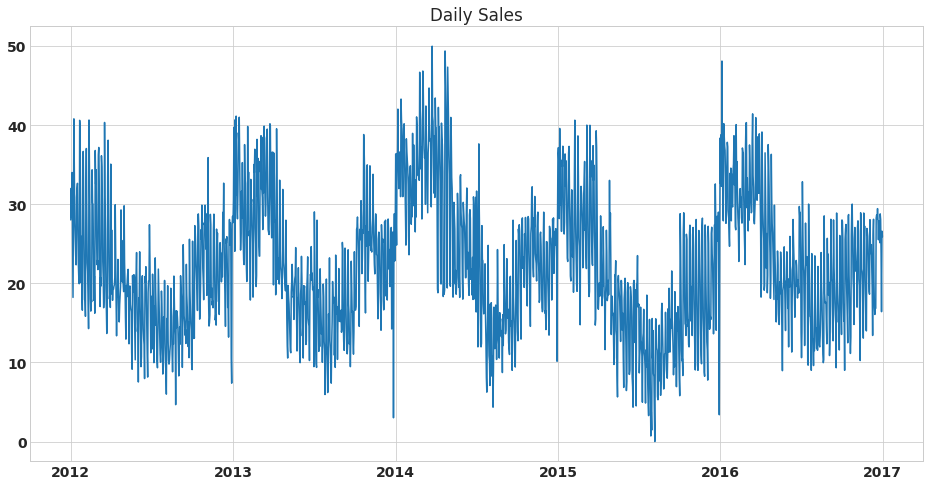

In [1871]:
# Global class to hold all parameters
@dataclass
class G:
    # Forecast of daily sales     
    TS = pd.read_csv('data/ts_daily.csv', sep = ';')
    TS['DATE'] = pd.to_datetime(TS['DATE'])
    TS.columns = ['date', 'sales']
    TS.index = TS['date']
    
    WINDOW_SIZE = 30 # One month window
    FORECAST_HORIZON = 365 # One year forecast
    FREQUENCY = 365 # Daily sales data
    BATCH_SIZE = 24 # Size of batches
    

def train_val_split(series, forecast_horizon):
    """Splits data into training and validation sets where the latter
    is the forecast horizon, the number of days of the multistep forecast.
    """
    series_train = series.iloc[:-forecast_horizon, :]
    time_train = series_train['date']
    
    series_valid = series.iloc[-forecast_horizon:, :]
    time_valid = series_valid['date']
    
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TS, G.FORECAST_HORIZON)
print("shape of training set: {}, shape of valid set: {}".format(series_train.shape, series_valid.shape)) 

def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data.

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """
    
    plt.figure(figsize=(16, 8))
    
    if type(y) is tuple:
      for y_curr in y:

        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      
      plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend:
      plt.legend(legend)

    plt.title(title)
    plt.grid(True)

    plt.show()

# Plot the whole series 
plot_series(G.TS['date'], G.TS['sales'], title='Daily Sales')

In [1807]:
G.TS.describe()

sales
count  1827.000000
mean     22.259080
std       8.529927
min       0.000000
25%      16.070547
50%      20.928149
75%      27.998848
max      50.000000

In [1808]:
G.TS.isnull().sum()

date     0
sales    0
dtype: int64

Around 2000 total sold products over 5 years ranging from no products being sold at all to 50 products sold in one day, leading to an average of around 22 products sold each day. There are no null values so next we can explore the data through visualizations and time series analysis.

# Explorative Data Analysis

In [1809]:
# Plotting daily sales with Plotly

daily_sales_sc = go.Scatter(x=G.TS['date'], y=G.TS['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

## Time Series Analysis

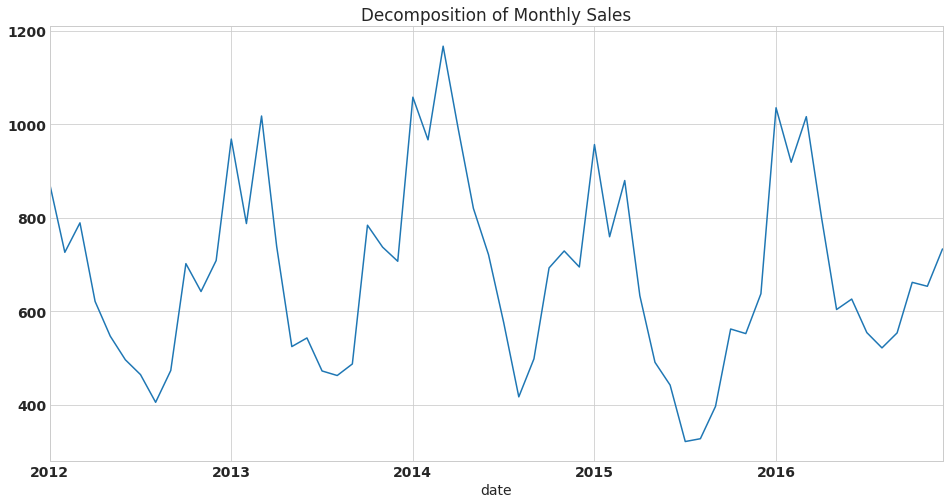

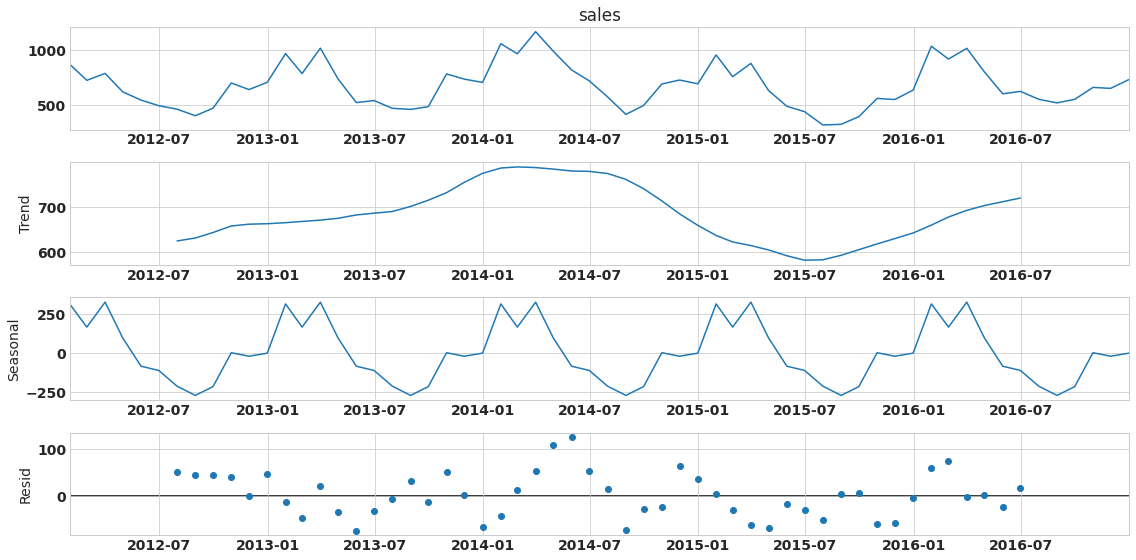

In [1810]:
# Sales decomposition

monthly_sales =  G.TS['sales'].resample('M').sum()
fig = monthly_sales.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Decomposition of Monthly Sales')
fig = seasonal_decompose(monthly_sales, model='additive', period=12).plot()
plt.show()

We notice an upward moving trend from 2012 to 2014, and then a downward sloping trend until June 2015, from where the product sales again start climbing upwards. We also notice a clear seasonal fluctuation that moves upward each year from June onwards until around March where the product sales start to slow down, the difference of the maximum and minimum peaks being around 250 product sales. The residual is close to zero the first two years of the series, but after we see more random fluctuations that cannot be explained by the trend and seasonal components alone.

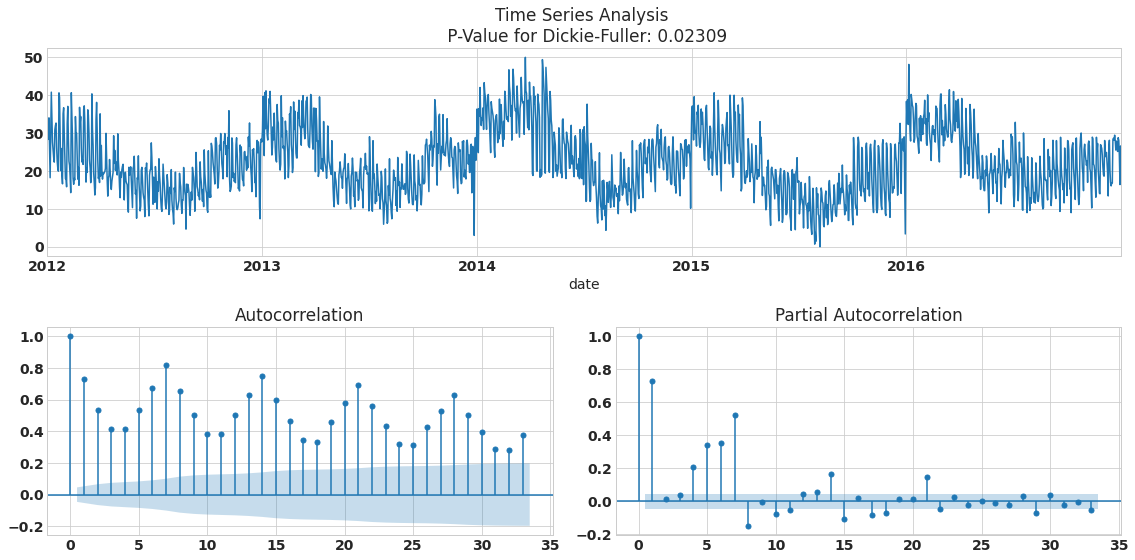

In [1811]:
# Time series analysis for product sales

def tsplot(y, lags=None):
    """
    Plots time series, ACF, PACF, and performs Augmented Dickey–Fuller test.

    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure()
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis \n P-Value for Dickie-Fuller: {0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(G.TS['sales'])

We can see that the series is stationary from the p-value of the Dickie-Fuller test so no further transformations are needed. The autocorrelation function indicates a decaying strong correlation that occurs at each first day of the week, and the last spike of over 0.6 correlation at day 28. The partial autocorrelation function has strong correlation on the first week, and after that, it decays and vanishes slowly towards zero.

# Feature Engineering

In [1812]:
# Function to calculate seasonal means

def calculate_seasonal_means(series, date_colname, y_colname, forecast_horizon, freq):
    """Calculates the seasonal means of a given time series

    Args:
        series (dataframe): pandas dataframe
        date_colname (str): Name of the date column in the given dataframe
        y_colname (str): Name of the target column in the given dataframe
        n_leads (int): number of period to forecast into the futur
        freq (int): frequency, periods of the time series (1=yearly, 12=monthly, 52=weekly, 365=daily)

    Returns:
        A list of strings representing the header columns
    """
    keep_cols = list(series.columns)
    
    ts = series[[date_colname, y_colname]].copy()

    ts.index.name = 'index'
    ts.index = pd.to_datetime(ts[date_colname])
    ts.index.name = 'index'
    
    min_year = np.min(ts.index.year)
    max_year = np.max(ts.index.year) + int(forecast_horizon/freq) + 5

    all_dates = pd.DataFrame(pd.date_range(pd.to_datetime(str(min_year) + '-01-01'),
                  pd.to_datetime(str(max_year) + '-12-31')-timedelta(days=1),freq='d'), columns = ['ds'])

    ts['day_of_month'] = ts.index.day
    ts['day_of_week'] = ts.index.dayofweek
    ts['week'] = ts.index.week
    ts['quarter'] = ts.index.quarter
    ts['month'] = ts.index.month
    ts['weekly_monthly'] = ts['day_of_week'].astype(str) + ts['week'].astype(str) + ts['month'].astype(str)    
    
    ts = ts.fillna(0)
    
    day_week_mean = ts[['day_of_week', y_colname]].groupby(['day_of_week']).mean([y_colname]).reset_index()
    day_week_mean.columns = ['day_of_week', 'day_of_week_mean']
    ts = pd.merge(ts, day_week_mean, how = 'left', left_on = 'day_of_week', right_on = 'day_of_week')
    
    day_month_mean = ts[['day_of_month', y_colname]].groupby(['day_of_month']).mean([y_colname]).reset_index()
    day_month_mean.columns = ['day_of_month', 'day_of_month_mean']
    ts = pd.merge(ts, day_month_mean, how = 'left', left_on = 'day_of_month', right_on = 'day_of_month')
        
    quarter_mean = ts[['quarter', y_colname]].groupby(['quarter']).mean([y_colname]).reset_index()
    quarter_mean.columns = ['quarter', 'quarter_mean']
    ts = pd.merge(ts, quarter_mean, how = 'left', left_on = 'quarter', right_on = 'quarter')
        
    week_mean = ts[['week', y_colname]].groupby(['week']).mean([y_colname]).reset_index()
    week_mean.columns = ['week', 'week_mean']
    ts = pd.merge(ts, week_mean, how = 'left', left_on = 'week', right_on = 'week')
            
    month_mean = ts[['month', y_colname]].groupby(['month']).mean([y_colname]).reset_index()
    month_mean.columns = ['month', 'month_mean']
    ts = pd.merge(ts, month_mean, how = 'left', left_on = 'month', right_on = 'month')
    
    week_month_mean = ts[['weekly_monthly', y_colname]].groupby(['weekly_monthly']).mean([y_colname]).reset_index()
    week_month_mean.columns = ['weekly_monthly', 'weekly_monthly_mean']
    ts = pd.merge(ts, week_month_mean, how = 'left', left_on = 'weekly_monthly', right_on = 'weekly_monthly')
    
    ts.index = pd.to_datetime(series[date_colname])
    
    add_cols = list(set(keep_cols) - set(ts.columns))
    
    for col in add_cols:
        
        ts[col] = dataset[col]

    return ts

seasonal_means = calculate_seasonal_means(G.TS, 'date', 'sales', G.FORECAST_HORIZON, G.FREQUENCY)

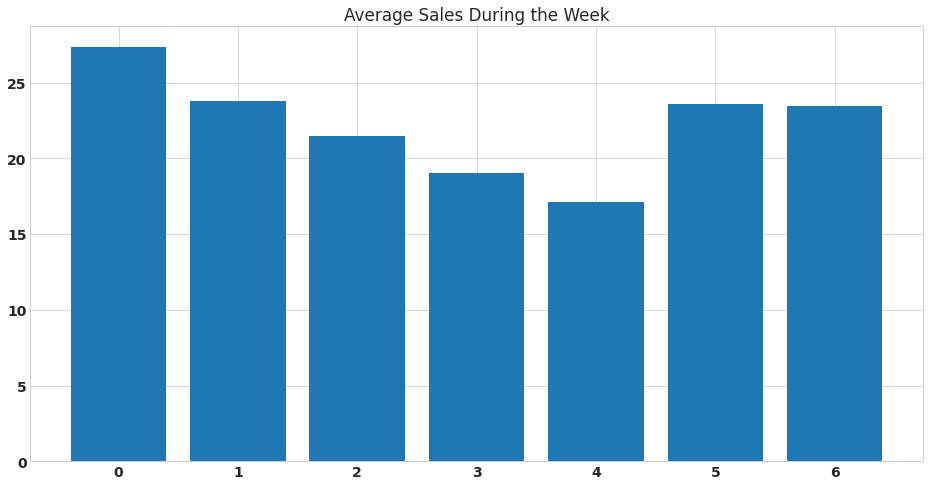

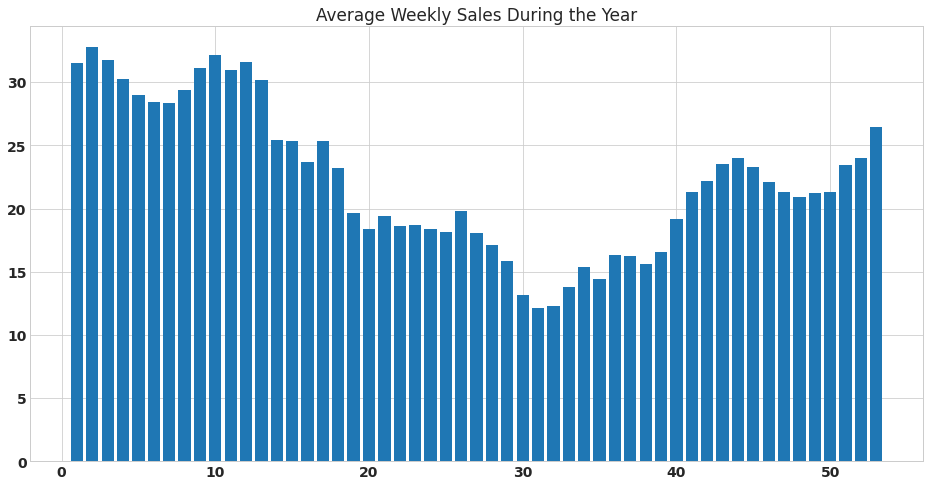

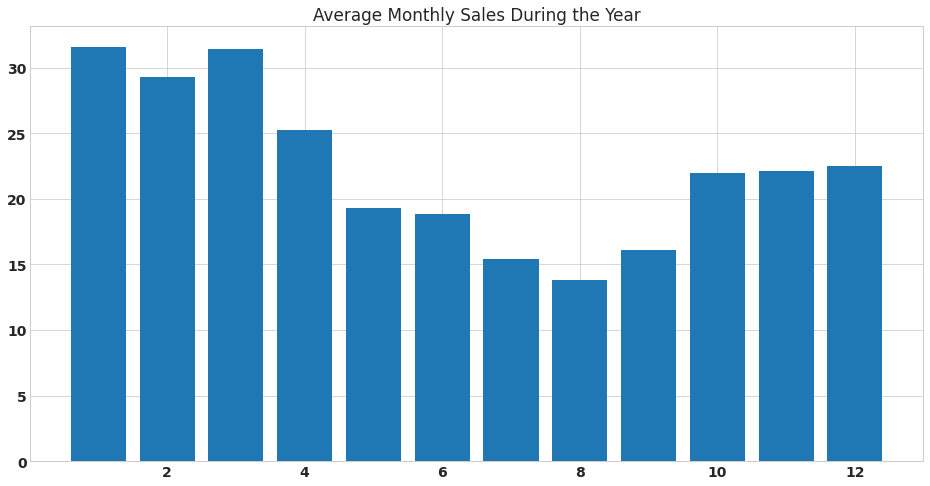

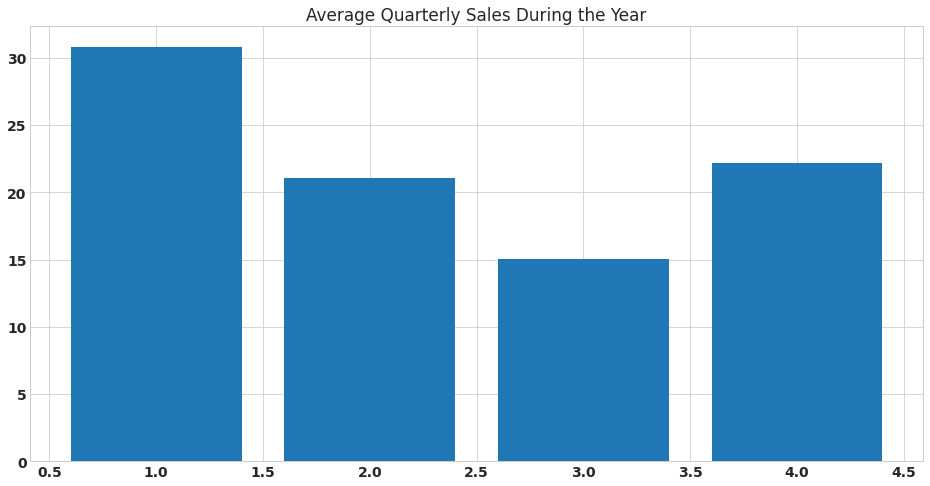

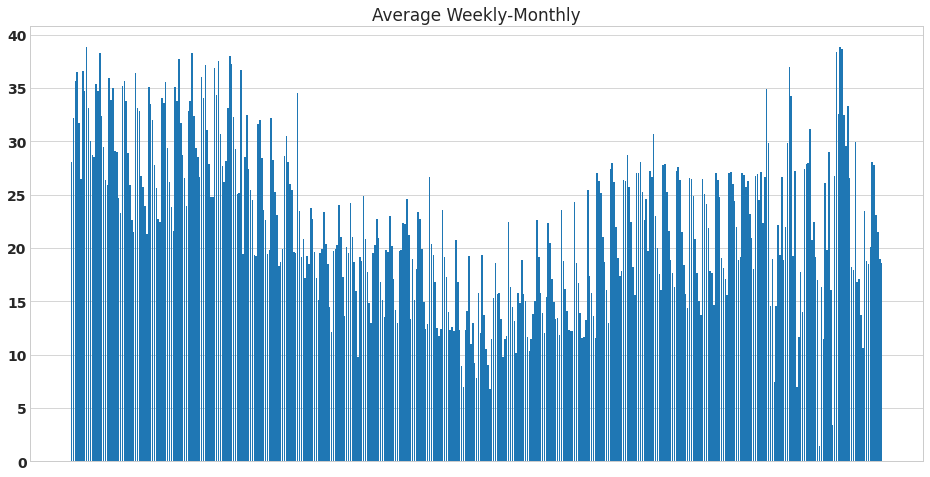

In [1813]:
# Plotting seasonal means

df = seasonal_means[['day_of_week','day_of_week_mean']].drop_duplicates()
plt.bar(df['day_of_week'], df['day_of_week_mean'])
plt.title('Average Sales During the Week')
plt.show()
    
df = seasonal_means[['week','week_mean']].drop_duplicates()
plt.bar(df['week'], df['week_mean'])
plt.title('Average Weekly Sales During the Year')
plt.show()
    
df = seasonal_means[['month','month_mean']].drop_duplicates()
plt.bar(df['month'], df['month_mean'])
plt.title('Average Monthly Sales During the Year')
plt.show()
    
df = seasonal_means[['quarter','quarter_mean']].drop_duplicates()
plt.bar(df['quarter'], df['quarter_mean'])
plt.title('Average Quarterly Sales During the Year')
plt.show()
    
df = seasonal_means[['weekly_monthly','weekly_monthly_mean']].drop_duplicates()
plt.bar(df['weekly_monthly'], df['weekly_monthly_mean'])
plt.title('Average Weekly-Monthly')
plt.xticks([])
plt.show()

In [1814]:
# Function to create sequences from the data set

def windowed_dataset(series, n_in=1, n_out=1):
    """Sequences take the form of a window, where the past timestep values
    are the features that are used to predict the future forecast sequence.
    """
    n_vars = 1 if type(series) is list else series.shape[1]
    
    cols, names = list(), list()
        
    for i in range(n_in, 0, -1): # lag sequence (t-n, ... t-1)
        cols.append(series.shift(i))
        if i < 10:
            name_i = '0' + str(i)
        else:
            name_i = str(i)
              
        names += [(str(pd.DataFrame(series.iloc[:, j]).columns.values).replace("']",'').replace("['",'') +'_' + 'lag' + name_i) for j in range(n_vars)]
        
    for i in range(0, n_out): # lead sequence (t, t+1, ... t+n)
        cols.append(series.shift(-i))
        if i == 0:
            names += [(str(pd.DataFrame(series.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
        else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(series.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + 'lead' + name_i) for j in range(n_vars)]
        
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    
    return agg

In [1877]:
# Function to transform series into forecasting tasks

def dataprep_forecasting(series, date_colname, y_colname):
    """Prepares the series for machine learning, first by scaling with the mean and standard deviation,
    then by calculating seasonal features, and finally sequencing the dataset into sequences.
    """
    
    scaler = StandardScaler()
    ts = series.copy()

    y = ts[[y_colname]].copy()

    y = pd.DataFrame(scaler.fit_transform(y))
    y.columns = [y_colname]
    
    for y_colname in y.columns:
        ts[y_colname] = y[y_colname].values
    
    all_cols = [date_colname, y_colname]

    ts_seasonal_means = calculate_seasonal_means(series[all_cols], date_colname, y_colname, G.FORECAST_HORIZON, G.FREQUENCY)
        
    ts_seasonal_means.index = pd.to_datetime(series[date_colname])
    
    del ts_seasonal_means[date_colname]
    del ts_seasonal_means[y_colname]

    ts.index = pd.to_datetime(ts[date_colname])
    
    ts_sequence = windowed_dataset(ts[[y_colname]], n_in=G.WINDOW_SIZE, n_out=1)
    
    ts_sequence.index = pd.to_datetime(ts_sequence.index)
    ts_sequence.index.name = 'index'
    
    ts_sequence['week'] = ts_sequence.index.week
    ts_sequence['month'] = ts_sequence.index.month
    ts_sequence['quarter'] = ts_sequence.index.quarter
    ts_sequence['day_of_month'] = ts_sequence.index.day
    ts_sequence['day_of_week'] = ts_sequence.index.dayofweek
    ts_sequence['weekly_monthly'] = ts_sequence['day_of_week'].astype(str) + ts_sequence['week'].astype(str) + ts_sequence['month'].astype(str)
    
    for feat in ['week',
                 'month',
                'quarter',
                'day_of_month',
                'day_of_week',
                'weekly_monthly']:
        if feat in ts_seasonal_means.columns:
            seasonal_features = ts_seasonal_means[[feat, feat+'_mean']].drop_duplicates().reset_index(drop = True)
            ts_sequence = pd.merge(ts_sequence, seasonal_features[[feat, feat+'_mean']], how = 'left', left_on = feat, right_on = feat)

            del ts_sequence[feat]
        else:
            try:
                del ts_sequence[feat]
            except:
                pass
            pass
    
    for col in ts_sequence.columns:
        ts_sequence[col] = ts_sequence[col].values
        
    for col in ts_seasonal_means.columns:
        if col in ts_sequence.columns:
            ts_sequence[col] = StandardScaler().fit_transform(ts_sequence[[col]]).ravel()
    
    return ts_sequence, scaler

train_set, scaler_train = dataprep_forecasting(series_train, 'date', 'sales') 
val_set, scaler_valid = dataprep_forecasting(series_valid, 'date', 'sales')
full_set, scaler_forecast = dataprep_forecasting(G.TS, 'date', 'sales')

print("shape of training set: {}, shape of valid set: {}, shape of full set {}".format(train_set.shape, val_set.shape, full_set.shape)) 

shape of training set: (1432, 37), shape of valid set: (335, 37), shape of full set (1797, 37)


In [1876]:
# Function to transform series into machine learning tasks

def dataprep_3D(series, y_colname, date_colname, forecast_horizon):
    """Creates the dataset into 3D tensors where the first component consist of
    the samples or the date of the product sales, the second being the forecast horizon,
    and third the features.
    """
    
    ts = series.copy()
    ts = ts[ts.columns.difference([date_colname])]

    x = ts[ts.columns.difference([date_colname])]
    y = ts[y_colname]
    feats = list(x.columns)
    
    x_list = []
    y_list = []
    i = 0
    
    for i in range(0, len(ts) - ((forecast_horizon*2)-1)):
        
        x_list.append([x.iloc[i: i+forecast_horizon].values])
        y_list.append([y.iloc[i+forecast_horizon: i+(forecast_horizon*2)][y_colname].values])
    
    x_seq = np.array(x_list).reshape(len(x) - ((forecast_horizon*2)-1), forecast_horizon, len(x.columns))
    y_seq = np.array(y_list).reshape(len(y) - ((forecast_horizon*2)-1), forecast_horizon, len(y_colname))


    val_seq = []
    i = 0
    
    for i in range(len(x) - forecast_horizon, len(x)- (forecast_horizon-1)):
        
        val_seq.append([x.iloc[i: i+forecast_horizon].values])
    
    val_seq = np.array(val_seq).reshape(1, forecast_horizon, len(x.columns))

    return x_seq, y_seq, val_seq, feats

X_train_sequence, y_train_sequence, X_test_sequence, feats = dataprep_3D(train_set, ['sales'], 'date', G.FORECAST_HORIZON)

X_train_full, y_train_full, X_forecast, feats = dataprep_3D(full_set, ['sales'], 'date', G.FORECAST_HORIZON)

print("shape of x training sequence: {}, shape of y training sequence: {}, shape of x testing sequence {}".format(X_train_sequence.shape, y_train_sequence.shape, X_test_sequence.shape)) 
print("shape of x full training sequence: {}, shape of y full training sequence: {}, shape of x forecasting sequence {}".format(X_train_full.shape, y_train_full.shape, X_forecast.shape)) 

shape of x training sequence: (703, 365, 37), shape of y training sequence: (703, 365, 1), shape of x testing sequence (1, 365, 37)
shape of x full training sequence: (1068, 365, 37), shape of y full training sequence: (1068, 365, 1), shape of x forecasting sequence (1, 365, 37)


In [1817]:
dict_explain_tensor = {}
x = 0 
for val in X_train_sequence.shape:
    if x == 0:
        dict_explain_tensor[val] = 'Number of rows (samples of product sales from time)'
    elif x == 1:
        dict_explain_tensor[val] = 'Sequence length - Number of steps to forecasts (forecast_horizon)'
    elif x == 2:
        dict_explain_tensor[val] = 'Number of columns (features)'
    print(val, dict_explain_tensor[val])
    x = x + 1

703 Number of rows (samples of product sales from time)
365 Sequence length - Number of steps to forecasts (forecast_horizon)
37 Number of columns (features)


In [1818]:
dict_explain_full_tensor = {}
x = 0 
for val in X_train_full.shape:
    if x == 0:
        dict_explain_full_tensor[val] = 'Number of rows (samples of product sales from time)'
    elif x == 1:
        dict_explain_full_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif x == 2:
        dict_explain_full_tensor[val] = 'Sequence length - Number of steps to forecasts (forecast_horizon)'
    print(val, dict_explain_full_tensor[val])
    x = x + 1

1068 Number of rows (samples of product sales from time)
365 Sequence length - Number of steps to forecasts (n_leads)
37 Sequence length - Number of steps to forecasts (forecast_horizon)


# Modeling

We will try different deep learning models such as the Long Short-Term Memory (LSTM) network, the Bidirectional LSTM, the Gated Recurrent Unit (GRU) network, and the Time2Vec (vector representation of time) to see how well they deal with the forecasting task. Finally, at the end we will do some combinations of the models in the form of ensemble modeling. 

The models will be trained and evaluated with the RMSE and MAE. After the first round of training, the second round will begin with the full training set that includes the validation set, and the goal will be to forecast the product sales for one year ahead time.

## LSTM

In [1819]:
# Create the model

input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def LSTM_model():
    model = tf.keras.models.Sequential([
     #   tf.keras.layers.LSTM(units=256, kernel_initializer='glorot_uniform', activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(units=input_dim, kernel_initializer = 'glorot_uniform', activation = 'tanh',return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=output_dim, activation = 'linear')
    ], name = 'LSTM_model')
   
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True) 
    model.compile(loss='mse', optimizer=opt)
    
    return model

model_lstm = LSTM_model()

In [1820]:
# Train the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=5)
history_lstm = model_lstm.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=50, 
                    batch_size = G.BATCH_SIZE, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:,:, :], 
                                       y_train_full[-G.FORECAST_HORIZON:,:, :]), 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
30/30 [==============================] - 5s 112ms/step - loss: 1.1365 - val_loss: 1.0844
Epoch 2/50
30/30 [==============================] - 3s 95ms/step - loss: 1.0784 - val_loss: 1.0216
Epoch 3/50
30/30 [==============================] - 3s 99ms/step - loss: 1.0293 - val_loss: 0.9797
Epoch 4/50
30/30 [==============================] - 3s 96ms/step - loss: 0.9865 - val_loss: 0.9499
Epoch 5/50
30/30 [==============================] - 3s 106ms/step - loss: 0.9555 - val_loss: 0.9297
Epoch 6/50
30/30 [==============================] - 3s 98ms/step - loss: 0.9329 - val_loss: 0.9147
Epoch 7/50
30/30 [==============================] - 3s 97ms/step - loss: 0.9071 - val_loss: 0.9204
Epoch 8/50
30/30 [==============================] - 3s 105ms/step - loss: 0.8829 - val_loss: 0.9189
Epoch 9/50
30/30 [==============================] - 4s 125ms/step - loss: 0.8799 - val_loss: 0.9666
Epoch 10/50
30/30 [==============================] - 3s 108ms/step - loss: 0.8353 - val_loss: 0.9558
Epoc

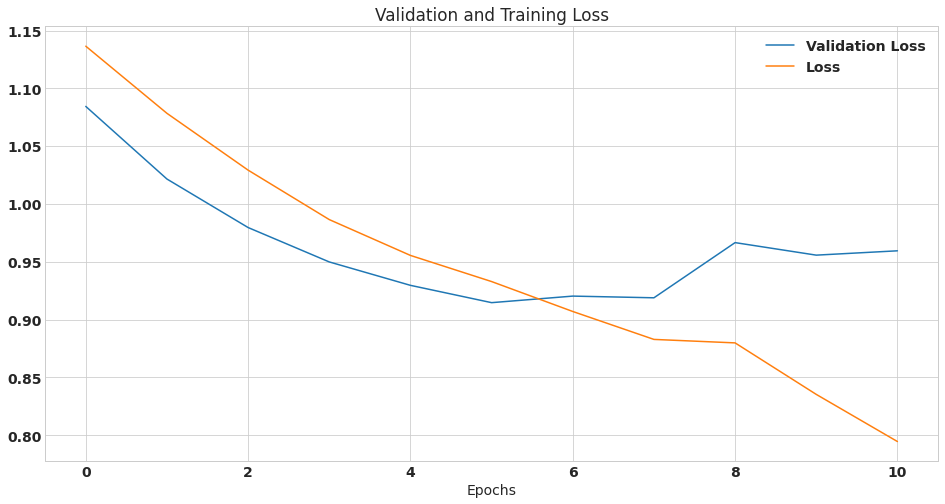

Best epoch : 5


In [1821]:
# Plot training loss

plot_series(
    x=range(len(history_lstm.history['loss'])), 
    y=(history_lstm.history['val_loss'], history_lstm.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_lstm.history)
hist['epoch'] = history_lstm.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch :', best_epoch)

In [1875]:
model_lstm.summary()

Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_225 (LSTM)             (None, 37)                11100     
                                                                 
 dropout_65 (Dropout)        (None, 37)                0         
                                                                 
 dense_222 (Dense)           (None, 365)               13870     
                                                                 
Total params: 24,970
Trainable params: 24,970
Non-trainable params: 0
_________________________________________________________________


In [1822]:
# Make forecast

pred_lstm = pd.DataFrame(model_lstm.predict(X_test_sequence)).T

1/1 [==============================] - 0s 336ms/step


In [1823]:
# Evaluate results

def compute_metrics(true_series, forecast):
    """
    Evaluate forecast with MSE and MAE.
    
    Args:
     true_series (array of int) - dataset for validating
     forecast (array of int) - forecast from the model
     
    Output:
     mse (metric) - mean squared error
     mae (metric) - mean absolute error
    """
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    
    return mse, mae

y_true = pd.DataFrame(G.TS['sales'][-G.FORECAST_HORIZON:].values.reshape(-1,1))

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_lstm[:]))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 6.389, mae: 5.238


In [1824]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)

model_lstm = create_LSTM()

history_lstm = model_lstm.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 24, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_lstm = model_lstm.predict(X_forecast).astype(float)
forecast_lstm_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_lstm).T)
forecast_lstm_df.columns = ['Y_PRED']

Epoch 1/5
45/45 [==============================] - 5s 82ms/step - loss: 1.1352
Epoch 2/5
45/45 [==============================] - 5s 102ms/step - loss: 1.0431
Epoch 3/5
45/45 [==============================] - 4s 83ms/step - loss: 0.9809
Epoch 4/5
45/45 [==============================] - 4s 80ms/step - loss: 0.9352
Epoch 5/5
1/1 [==============================] - 0s 290ms/step


In [1825]:
# Create index for forecast

def create_forecast_index(series, date_colname, forecast_horizon):
    
    forecast_dates = pd.DataFrame([ max(series.index) + relativedelta(days=1) ])
    
    if forecast_horizon >= 2:
        for i in range(2, forecast_horizon+1):
            forecast_dates = forecast_dates.append([max(series.index) + relativedelta(days=i)])    
        forecast_dates.columns = [date_colname] 
        forecast_dates.index = forecast_dates[date_colname]             
    
    else:
        forecast_dates.columns = [date_colname] 
        forecast_dates.index = X_pred_date[date_colname]     
   
            
    return forecast_dates

forecast_dates = create_forecast_index(G.TS, 'date', G.FORECAST_HORIZON)
forecast_lstm_df.index = forecast_dates.index

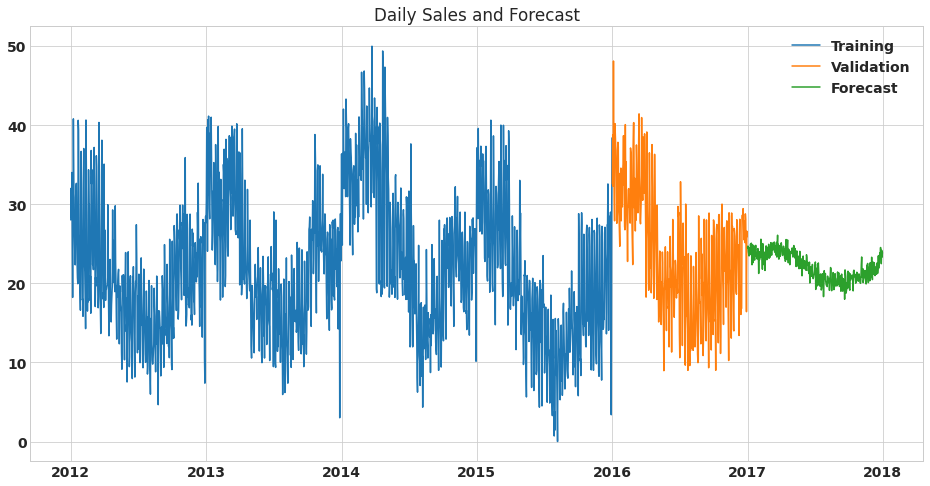

In [1826]:
# Plot whole series + forecast

fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_lstm_df.index, forecast_lstm_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

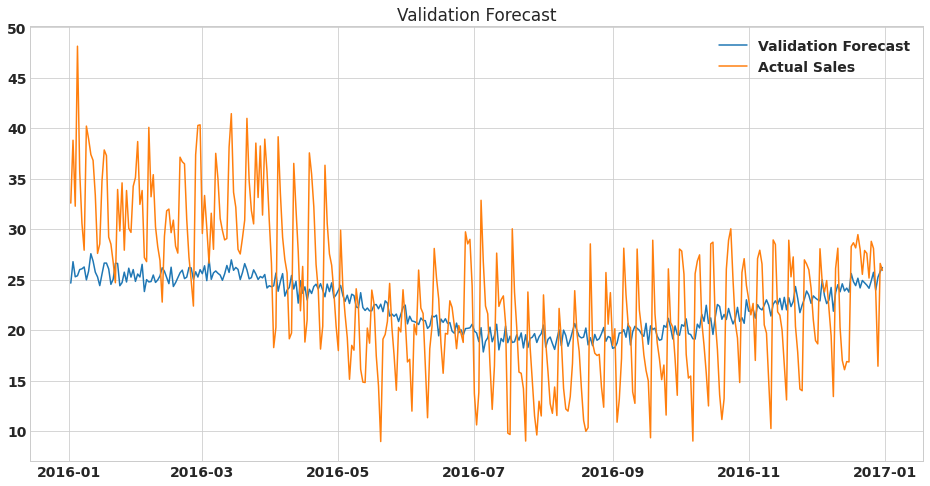

In [1827]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_lstm),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

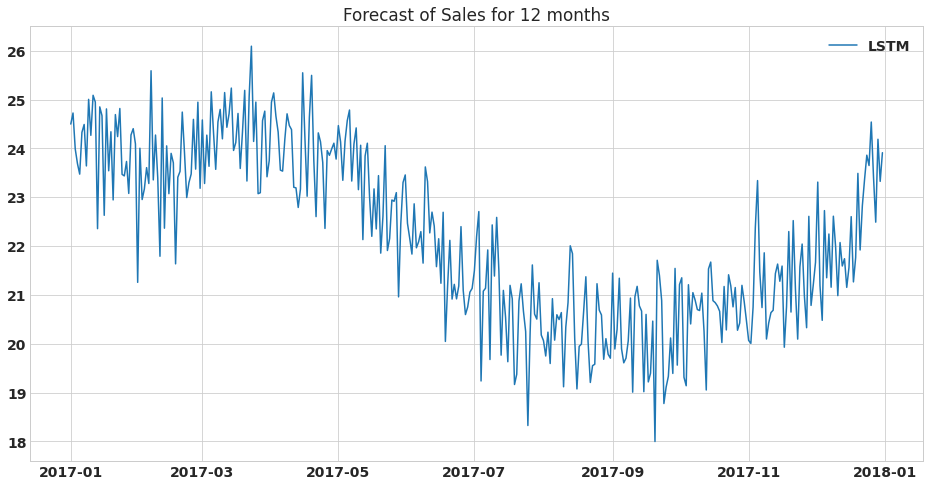

In [1828]:
# Forecast for 1 year ahead

plot_series(forecast_lstm_df.index, forecast_lstm_df, title='Forecast of Sales for 12 months', legend=['LSTM'])

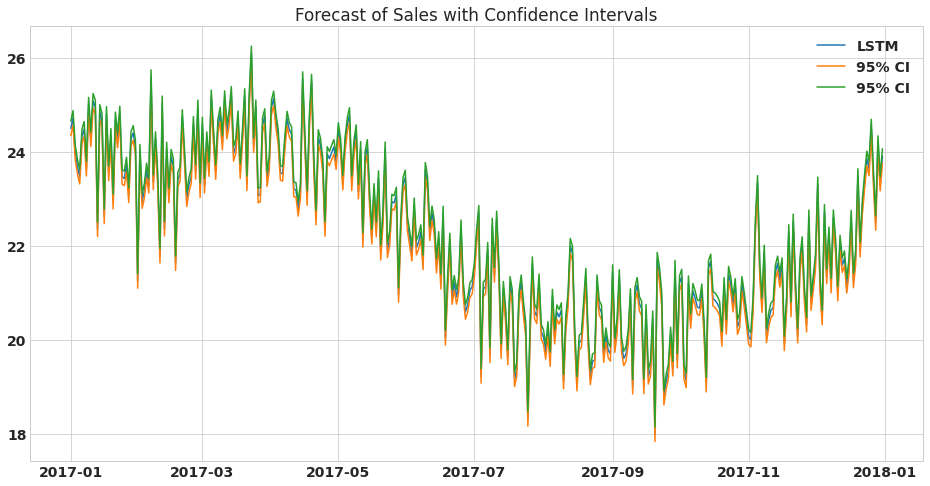

In [1829]:
# Forecast for 1 year ahead with 95 % confidence intervals

ci = 1.960*forecast_lstm_df.std(axis=0)/forecast_lstm_df.mean(axis=0)
ci_minus = [x - ci for x in forecast_lstm_df.values]
ci_plus = [x + ci for x in forecast_lstm_df.values]

plot_series(forecast_lstm_df.index, (forecast_lstm_df, ci_minus, ci_plus), legend=['LSTM','95% CI','95% CI'], title='Forecast of Sales with Confidence Intervals')

## BiLSTM

In [1830]:
# Creating the model
input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def BILSTM_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(LSTM(units=input_dim,
                                          return_sequences=False,
                                          kernel_initializer = 'glorot_uniform',
                                          activation = 'tanh')),
       # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=output_dim, activation = 'linear')
    ], name='Bidirectional-LSTM_model')
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4) 
    model.compile(loss='mse', optimizer=opt)
    
    return model

model_bilstm = BILSTM_model()

In [1831]:
# Training the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=7)
history_bilstm = model_bilstm.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs = 150, 
                    batch_size = G.BATCH_SIZE, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:,:, :], 
                                       y_train_full[-G.FORECAST_HORIZON:,:, :]), 
                    shuffle = False,
                    verbose = 1,
                    callbacks = [early_stop])

Epoch 1/150
30/30 [==============================] - 9s 193ms/step - loss: 1.1419 - val_loss: 1.1416
Epoch 2/150
30/30 [==============================] - 6s 188ms/step - loss: 1.1215 - val_loss: 1.1232
Epoch 3/150
30/30 [==============================] - 8s 276ms/step - loss: 1.1033 - val_loss: 1.1053
Epoch 4/150
30/30 [==============================] - 5s 175ms/step - loss: 1.0852 - val_loss: 1.0879
Epoch 5/150
30/30 [==============================] - 8s 274ms/step - loss: 1.0666 - val_loss: 1.0707
Epoch 6/150
30/30 [==============================] - 5s 179ms/step - loss: 1.0478 - val_loss: 1.0541
Epoch 7/150
30/30 [==============================] - 6s 201ms/step - loss: 1.0290 - val_loss: 1.0383
Epoch 8/150
30/30 [==============================] - 8s 255ms/step - loss: 1.0106 - val_loss: 1.0237
Epoch 9/150
30/30 [==============================] - 5s 177ms/step - loss: 0.9931 - val_loss: 1.0106
Epoch 10/150
30/30 [==============================] - 8s 277ms/step - loss: 0.9765 - val_lo

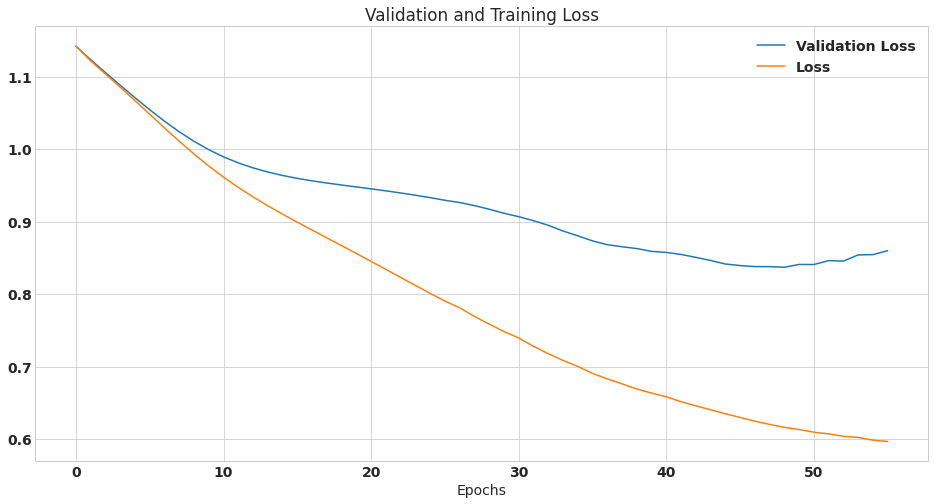

Best epoch : 48


In [1832]:
# Plot training loss

plot_series(
    x=range(len(history_bilstm.history['loss'])), 
    y=(history_bilstm.history['val_loss'], history_bilstm.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_bilstm.history)
hist['epoch'] = history_bilstm.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch :', best_epoch)

In [1874]:
model_bilstm.summary()

Model: "Bidirectional-LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_175 (Bidirect  (None, 74)               22200     
 ional)                                                          
                                                                 
 dense_224 (Dense)           (None, 365)               27375     
                                                                 
Total params: 49,575
Trainable params: 49,575
Non-trainable params: 0
_________________________________________________________________


In [1833]:
# Make forecast

pred_bilstm = pd.DataFrame(model_bilstm.predict(X_test_sequence)).T

1/1 [==============================] - 1s 562ms/step


In [1834]:
# Evaluate results

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_bilstm))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 6.049, mae: 4.877


In [1835]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)

model_bilstm = BILSTM_model()

history_bilstm = model_bilstm.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = G.BATCH_SIZE, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_bilstm = model_bilstm.predict(X_forecast).astype(float)
forecast_bilstm_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_bilstm).T)
forecast_bilstm_df.columns = ['Y_PRED']

Epoch 1/48
45/45 [==============================] - 12s 215ms/step - loss: 1.1798
Epoch 2/48
45/45 [==============================] - 7s 146ms/step - loss: 1.1471
Epoch 3/48
45/45 [==============================] - 9s 211ms/step - loss: 1.1189
Epoch 4/48
45/45 [==============================] - 7s 145ms/step - loss: 1.0908
Epoch 5/48
45/45 [==============================] - 9s 212ms/step - loss: 1.0621
Epoch 6/48
45/45 [==============================] - 7s 147ms/step - loss: 1.0336
Epoch 7/48
45/45 [==============================] - 10s 213ms/step - loss: 1.0068
Epoch 8/48
45/45 [==============================] - 7s 146ms/step - loss: 0.9829
Epoch 9/48
45/45 [==============================] - 10s 213ms/step - loss: 0.9622
Epoch 10/48
45/45 [==============================] - 7s 150ms/step - loss: 0.9446
Epoch 11/48
45/45 [==============================] - 10s 225ms/step - loss: 0.9292
Epoch 12/48
45/45 [==============================] - 7s 162ms/step - loss: 0.9153
Epoch 13/48
45/45 [==

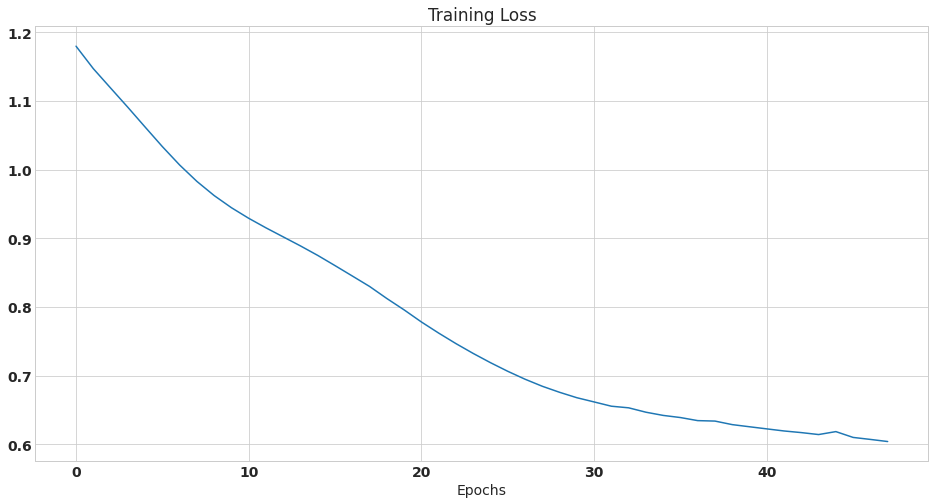

In [1836]:
# Plot training loss

plot_series(
    x=range(len(history_bilstm.history['loss'])), 
    y=history_bilstm.history['loss'], 
    title='Training Loss', 
    xlabel='Epochs'
    )

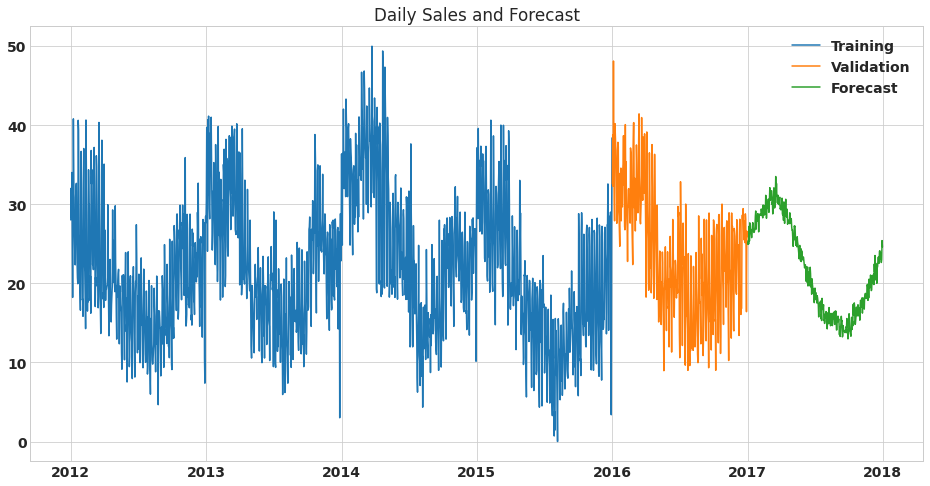

In [1837]:
# Plot whole series + forecast

forecast_bilstm_df.index = forecast_dates.index
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_bilstm_df.index, forecast_bilstm_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

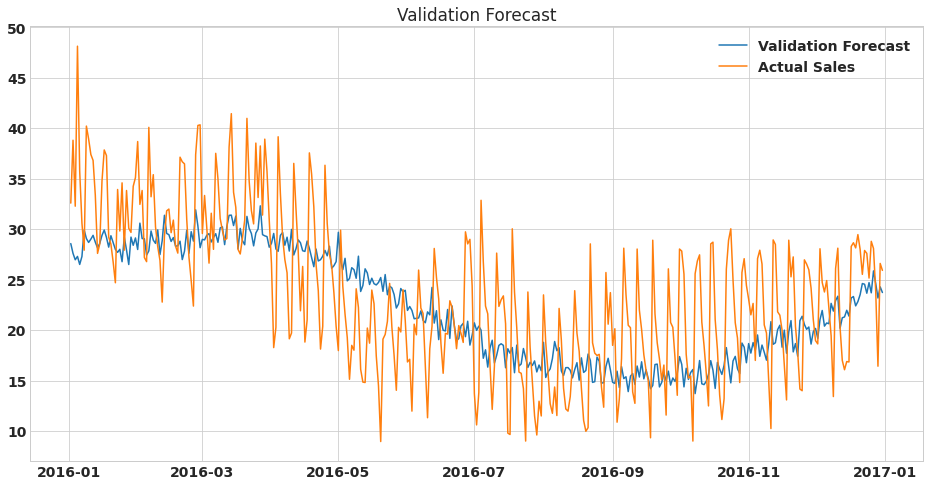

In [1838]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_bilstm),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

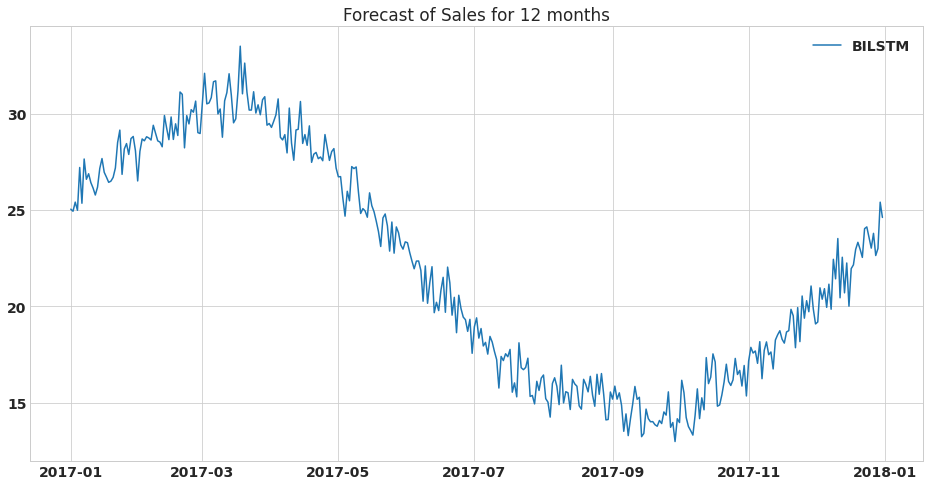

In [1839]:
# Forecast for 1 year ahead

plot_series(forecast_bilstm_df.index, forecast_bilstm_df, title='Forecast of Sales for 12 months', legend=['BILSTM'])

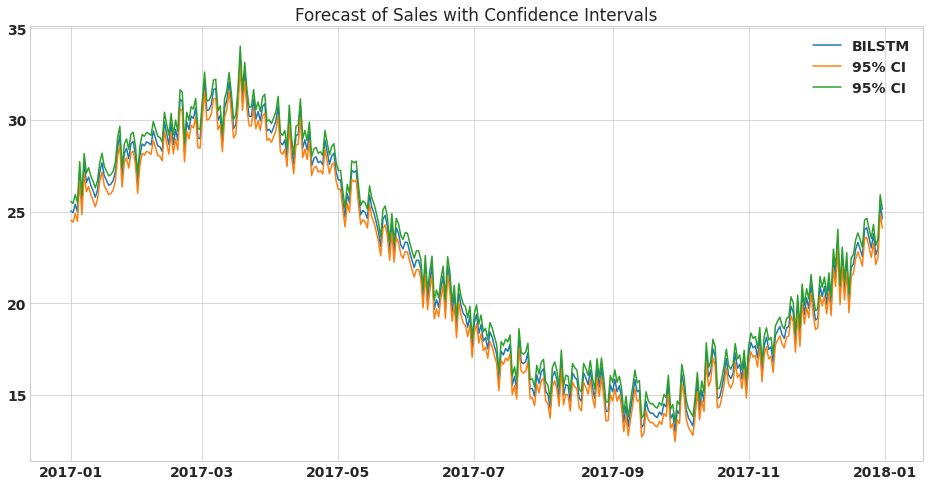

In [1840]:
# Forecast for 1 year ahead with 95 % confidence intervals

ci = 1.960*forecast_bilstm_df.std(axis=0)/forecast_bilstm_df.mean(axis=0)
ci_minus = [x - ci for x in forecast_bilstm_df.values]
ci_plus = [x + ci for x in forecast_bilstm_df.values]

plot_series(forecast_bilstm_df.index, (forecast_bilstm_df, ci_minus, ci_plus), legend=['BILSTM','95% CI','95% CI'], title='Forecast of Sales with Confidence Intervals')

## GRU

In [1841]:
# Create the model

input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def GRU_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(units = input_dim,
                           return_sequences = False,
                           kernel_initializer = 'glorot_uniform',
                           activation = 'tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units = output_dim, activation = 'linear')
    ], name = 'GRU_model')
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4) #learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True
    model.compile(loss='mse', optimizer=opt)
    
    return model

model_gru = GRU_model()

In [1842]:
# Train the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=5)
history_gru = model_gru.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=250, 
                    batch_size = 24, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:,:, :], 
                                       y_train_full[-G.FORECAST_HORIZON:,:, :]), 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/250
30/30 [==============================] - 7s 174ms/step - loss: 1.1654 - val_loss: 1.1565
Epoch 2/250
30/30 [==============================] - 3s 107ms/step - loss: 1.1503 - val_loss: 1.1430
Epoch 3/250
30/30 [==============================] - 3s 100ms/step - loss: 1.1384 - val_loss: 1.1305
Epoch 4/250
30/30 [==============================] - 4s 131ms/step - loss: 1.1264 - val_loss: 1.1182
Epoch 5/250
30/30 [==============================] - 5s 161ms/step - loss: 1.1153 - val_loss: 1.1054
Epoch 6/250
30/30 [==============================] - 3s 98ms/step - loss: 1.1044 - val_loss: 1.0921
Epoch 7/250
30/30 [==============================] - 3s 101ms/step - loss: 1.0924 - val_loss: 1.0781
Epoch 8/250
30/30 [==============================] - 3s 106ms/step - loss: 1.0804 - val_loss: 1.0635
Epoch 9/250
30/30 [==============================] - 5s 176ms/step - loss: 1.0673 - val_loss: 1.0487
Epoch 10/250
30/30 [==============================] - 3s 111ms/step - loss: 1.0553 - val_los

30/30 [==============================] - 4s 120ms/step - loss: 0.7778 - val_loss: 0.8566
Epoch 82/250
30/30 [==============================] - 3s 100ms/step - loss: 0.7782 - val_loss: 0.8553
Epoch 83/250
30/30 [==============================] - 3s 105ms/step - loss: 0.7718 - val_loss: 0.8544
Epoch 84/250
30/30 [==============================] - 5s 176ms/step - loss: 0.7664 - val_loss: 0.8533
Epoch 85/250
30/30 [==============================] - 5s 158ms/step - loss: 0.7685 - val_loss: 0.8524
Epoch 86/250
30/30 [==============================] - 4s 130ms/step - loss: 0.7629 - val_loss: 0.8513
Epoch 87/250
30/30 [==============================] - 4s 137ms/step - loss: 0.7610 - val_loss: 0.8502
Epoch 88/250
30/30 [==============================] - 6s 215ms/step - loss: 0.7562 - val_loss: 0.8493
Epoch 89/250
30/30 [==============================] - 4s 128ms/step - loss: 0.7520 - val_loss: 0.8484
Epoch 90/250
30/30 [==============================] - 4s 123ms/step - loss: 0.7518 - val_loss: 

Epoch 161/250
30/30 [==============================] - 3s 100ms/step - loss: 0.6073 - val_loss: 0.7085
Epoch 162/250
30/30 [==============================] - 3s 99ms/step - loss: 0.6105 - val_loss: 0.7065
Epoch 163/250
30/30 [==============================] - 4s 134ms/step - loss: 0.6054 - val_loss: 0.7066
Epoch 164/250
30/30 [==============================] - 5s 161ms/step - loss: 0.6094 - val_loss: 0.7052
Epoch 165/250
30/30 [==============================] - 3s 100ms/step - loss: 0.5997 - val_loss: 0.7026
Epoch 166/250
30/30 [==============================] - 3s 100ms/step - loss: 0.6026 - val_loss: 0.7018
Epoch 167/250
30/30 [==============================] - 3s 107ms/step - loss: 0.5969 - val_loss: 0.7008
Epoch 168/250
30/30 [==============================] - 5s 181ms/step - loss: 0.5945 - val_loss: 0.6994
Epoch 169/250
30/30 [==============================] - 3s 106ms/step - loss: 0.5983 - val_loss: 0.6977
Epoch 170/250
30/30 [==============================] - 3s 100ms/step - los

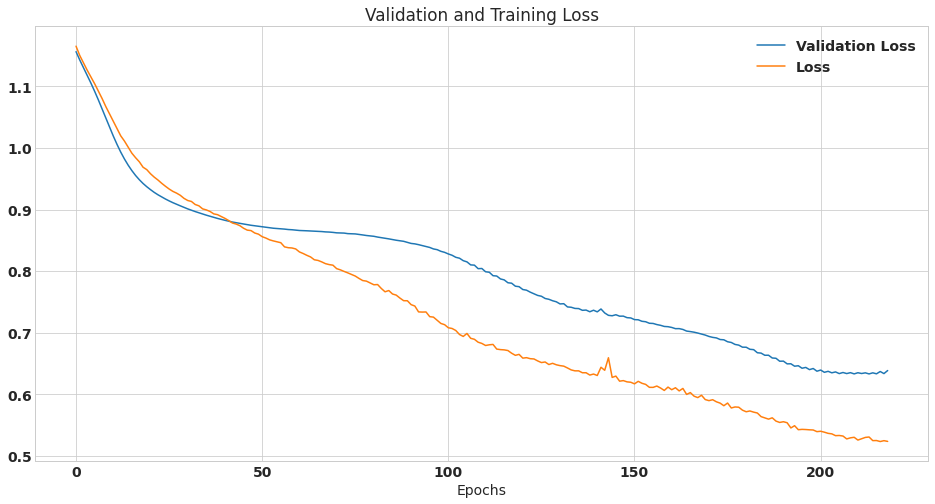

Best epoch for lowest validation loss: 213


In [1843]:
# Plot training loss

plot_series(
    x=range(len(history_gru.history['loss'])), 
    y=(history_gru.history['val_loss'], history_gru.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_gru.history)
hist['epoch'] = history_gru.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch for lowest validation loss:', best_epoch)

In [1873]:
model_gru.summary()

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 37)                8436      
                                                                 
 dropout_67 (Dropout)        (None, 37)                0         
                                                                 
 dense_226 (Dense)           (None, 365)               13870     
                                                                 
Total params: 22,306
Trainable params: 22,306
Non-trainable params: 0
_________________________________________________________________


In [1844]:
# Make forecast

pred_gru = pd.DataFrame(model_gru.predict(X_test_sequence)).T

1/1 [==============================] - 0s 293ms/step


In [1845]:
# Evaluating results

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_gru))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 5.733, mae: 4.666


In [1846]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)


model_gru = GRU_model()

history_bilstm = model_gru.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = G.BATCH_SIZE, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_gru = model_gru.predict(X_forecast).astype(float)
forecast_gru_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_gru).T)
forecast_gru_df.columns = ['Y_PRED']

Epoch 1/213
45/45 [==============================] - 9s 139ms/step - loss: 1.1997
Epoch 2/213
45/45 [==============================] - 4s 97ms/step - loss: 1.1713
Epoch 3/213
45/45 [==============================] - 4s 95ms/step - loss: 1.1468
Epoch 4/213
45/45 [==============================] - 7s 164ms/step - loss: 1.1247
Epoch 5/213
45/45 [==============================] - 4s 92ms/step - loss: 1.1004
Epoch 6/213
45/45 [==============================] - 4s 98ms/step - loss: 1.0803
Epoch 7/213
45/45 [==============================] - 7s 157ms/step - loss: 1.0599
Epoch 8/213
45/45 [==============================] - 4s 91ms/step - loss: 1.0416
Epoch 9/213
45/45 [==============================] - 4s 90ms/step - loss: 1.0263
Epoch 10/213
45/45 [==============================] - 6s 136ms/step - loss: 1.0129
Epoch 11/213
45/45 [==============================] - 5s 113ms/step - loss: 1.0022
Epoch 12/213
45/45 [==============================] - 4s 89ms/step - loss: 0.9911
Epoch 13/213
45/45 [

45/45 [==============================] - 7s 151ms/step - loss: 0.5865
Epoch 101/213
45/45 [==============================] - 4s 93ms/step - loss: 0.5834
Epoch 102/213
45/45 [==============================] - 4s 90ms/step - loss: 0.5835
Epoch 103/213
45/45 [==============================] - 7s 148ms/step - loss: 0.5809
Epoch 104/213
45/45 [==============================] - 5s 104ms/step - loss: 0.5800
Epoch 105/213
45/45 [==============================] - 4s 92ms/step - loss: 0.5798
Epoch 106/213
45/45 [==============================] - 6s 136ms/step - loss: 0.5794
Epoch 107/213
45/45 [==============================] - 5s 116ms/step - loss: 0.5762
Epoch 108/213
45/45 [==============================] - 4s 94ms/step - loss: 0.5748
Epoch 109/213
45/45 [==============================] - 5s 121ms/step - loss: 0.5737
Epoch 110/213
45/45 [==============================] - 6s 126ms/step - loss: 0.5702
Epoch 111/213
45/45 [==============================] - 4s 91ms/step - loss: 0.5718
Epoch 112/2

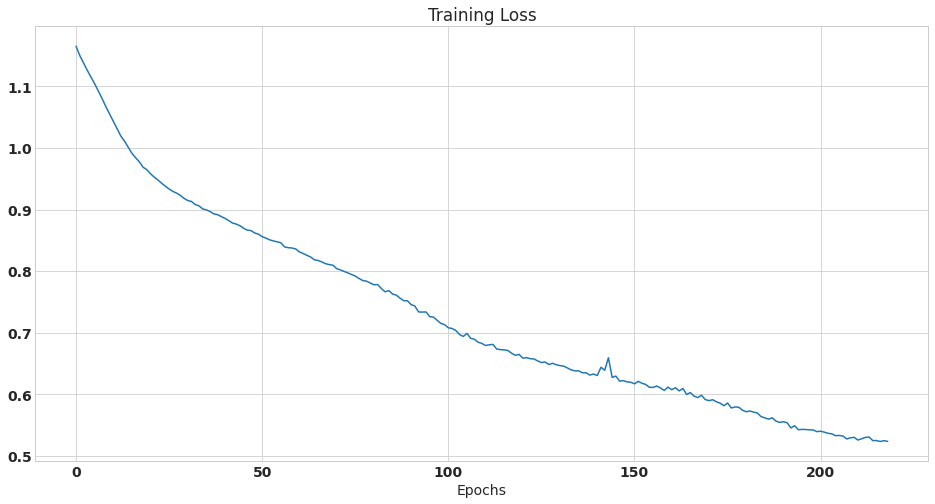

In [1847]:
# Plot training loss

plot_series(
    x=range(len(history_gru.history['loss'])), 
    y=history_gru.history['loss'], 
    title='Training Loss', 
    xlabel='Epochs'
    )

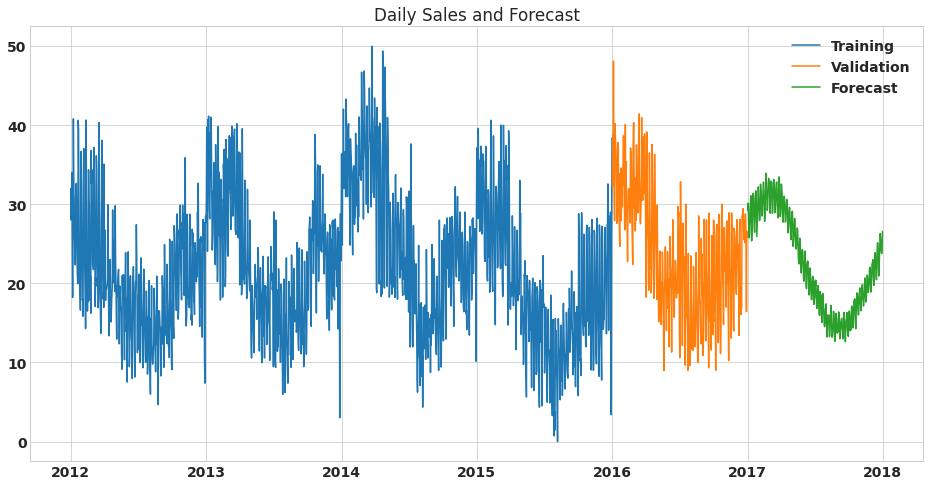

In [1848]:
# Plot whole series + forecast

forecast_gru_df.index = forecast_dates.index
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_gru_df.index, forecast_gru_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

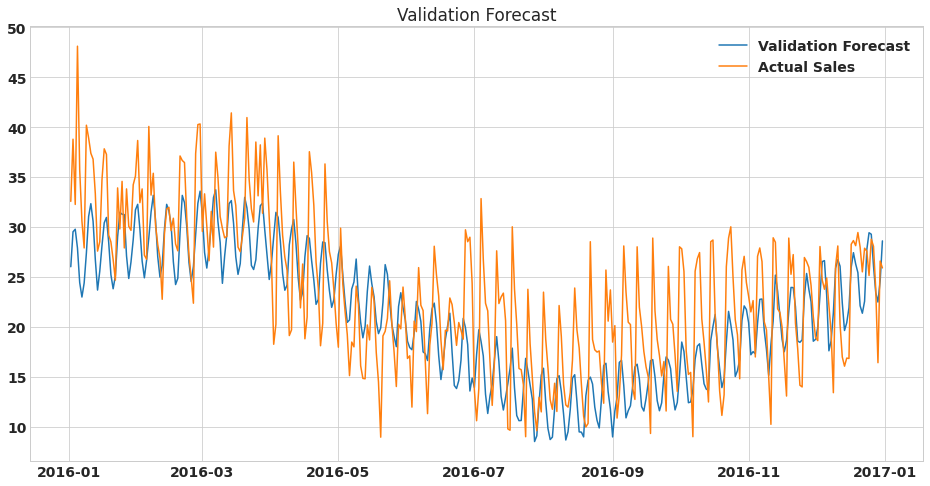

In [1849]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_gru),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

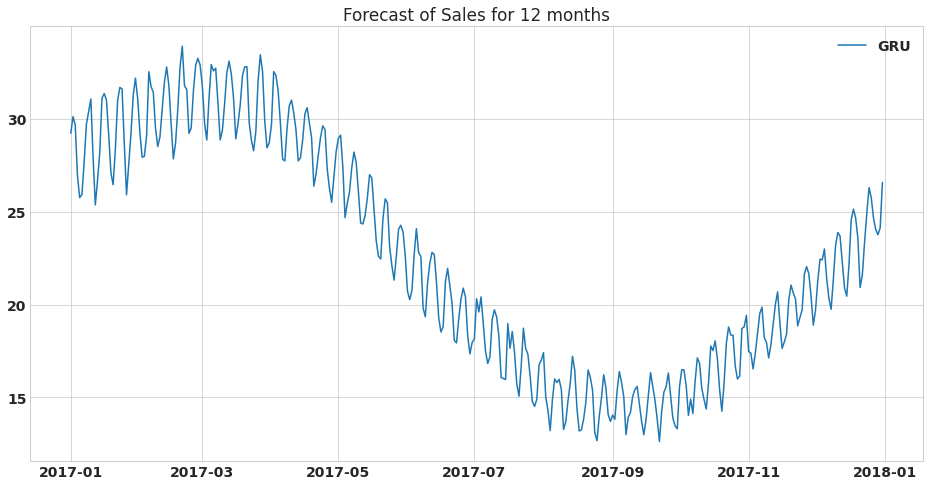

In [1850]:
# Forecast for 1 year ahead

plot_series(forecast_gru_df.index, forecast_gru_df, title='Forecast of Sales for 12 months', legend=['GRU'])

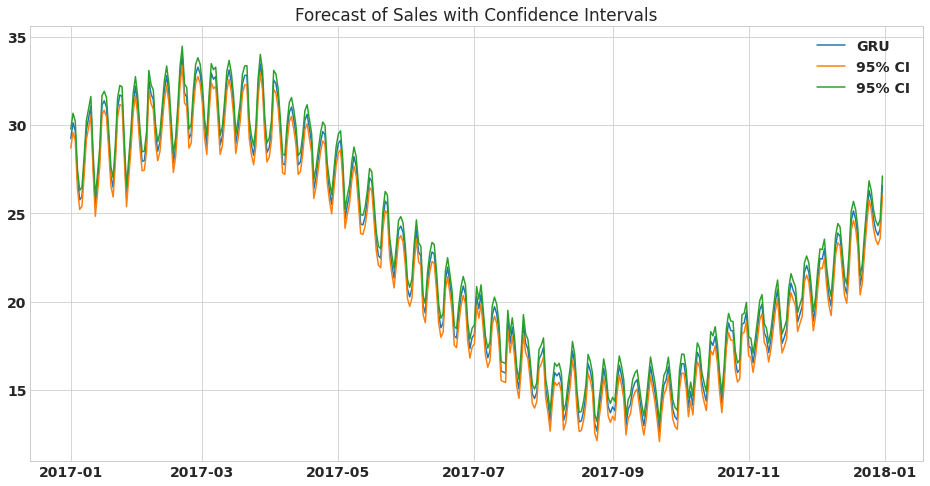

In [1851]:
# Forecast for 1 year ahead with 95 % confidence intervals

ci = 1.960*forecast_gru_df.std(axis=0)/forecast_gru_df.mean(axis=0)
ci_minus = [x - ci for x in forecast_gru_df.values]
ci_plus = [x + ci for x in forecast_gru_df.values]

plot_series(forecast_gru_df.index, (forecast_gru_df, ci_minus, ci_plus), legend=['GRU','95% CI','95% CI'], title='Forecast of Sales with Confidence Intervals')

## Time2Vec-BiLSTM

In [1872]:
# Creating Time2Vec layer for the model

class Time2Vec(Layer):
    """S. M. Kazemi, R. Goel, S. Eghbali, J. Ramanan, J. Sahota, S. Thakur,
    S. Wu, C. Smyth, P. Poupart,  and M. Brubaker, (2019),
    "Time2Vec: Learning a Vector Representation of Time.", arXiv:1907.0532lvl 
    """
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [1853]:
# Creating the model

def T2V_BILSTM_model():
    inp = Input(shape=(X_train_sequence.shape[1],
                   X_train_sequence.shape[2]))
    x = Time2Vec(120)(inp)
    x = Bidirectional(LSTM(48, activation='tanh', return_sequences = True))(x)
    x = Dense(y_train_sequence.shape[1])(x)

    model = Model(inp, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True) 
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model
    
model_t2v = T2V_BILSTM_model()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 365, 37)]         0         
                                                                 
 time2_vec_35 (Time2Vec)     (None, 365, 157)          48970     
                                                                 
 bidirectional_176 (Bidirect  (None, 365, 96)          79104     
 ional)                                                          
                                                                 
 dense_227 (Dense)           (None, 365, 365)          35405     
                                                                 
Total params: 163,479
Trainable params: 163,479
Non-trainable params: 0
_________________________________________________________________


In [1854]:
# Training the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=8)
history_t2v = model_t2v.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=150, 
                    batch_size = 24, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:, :, :],
                                       y_train_full[-G.FORECAST_HORIZON:, :, :]), 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/150
30/30 [==============================] - 22s 621ms/step - loss: 1.0309 - val_loss: 0.8157
Epoch 2/150
30/30 [==============================] - 17s 562ms/step - loss: 0.7228 - val_loss: 0.6785
Epoch 3/150
30/30 [==============================] - 17s 562ms/step - loss: 0.6351 - val_loss: 0.6339
Epoch 4/150
30/30 [==============================] - 16s 544ms/step - loss: 0.5928 - val_loss: 0.5144
Epoch 5/150
30/30 [==============================] - 16s 554ms/step - loss: 0.5224 - val_loss: 0.5037
Epoch 6/150
30/30 [==============================] - 16s 550ms/step - loss: 0.4695 - val_loss: 0.5087
Epoch 7/150
30/30 [==============================] - 16s 545ms/step - loss: 0.4356 - val_loss: 0.4890
Epoch 8/150
30/30 [==============================] - 16s 541ms/step - loss: 0.4110 - val_loss: 0.4807
Epoch 9/150
30/30 [==============================] - 16s 536ms/step - loss: 0.3936 - val_loss: 0.4874
Epoch 10/150
30/30 [==============================] - 16s 538ms/step - loss: 0.372

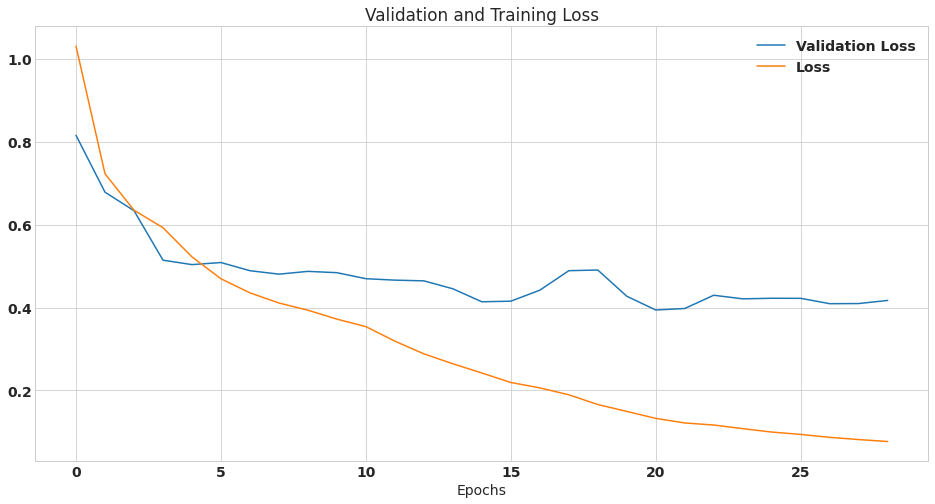

Best epoch for lowest validation loss: 20


In [1855]:
# Plot training loss

plot_series(
    x=range(len(history_t2v.history['loss'])), 
    y=(history_t2v.history['val_loss'], history_t2v.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_t2v.history)
hist['epoch'] = history_t2v.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch for lowest validation loss:', best_epoch)

In [1856]:
# Make forecast

pred_t2v = pd.DataFrame(model_t2v.predict(X_forecast)[0,:].T) # transform 3D to 2D
pred_t2v = pd.DataFrame(np.mean(pred_t2v.T, axis = 1))

1/1 [==============================] - 1s 578ms/step


In [1857]:
# Evaluating results

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_t2v))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 6.727, mae: 5.513


In [1858]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)


model_t2v = T2V_BILSTM_model()

history_t2v = model_t2v.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = G.BATCH_SIZE, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_t2v = pd.DataFrame(np.mean(model_t2v.predict(X_forecast), axis= 0)).astype(float) # shape (1, 365, 365)
forecast_t2v = pd.DataFrame(np.mean(forecast_t2v, axis = 1))
forecast_t2v_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_t2v))
forecast_t2v_df.columns = ['Y_PRED']

Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 365, 37)]         0         
                                                                 
 time2_vec_36 (Time2Vec)     (None, 365, 157)          48970     
                                                                 
 bidirectional_177 (Bidirect  (None, 365, 96)          79104     
 ional)                                                          
                                                                 
 dense_228 (Dense)           (None, 365, 365)          35405     
                                                                 
Total params: 163,479
Trainable params: 163,479
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
45/45 [==============================] - 24s 482ms/step - loss: 0.9771
Epoch 2/20
45/45 [==================

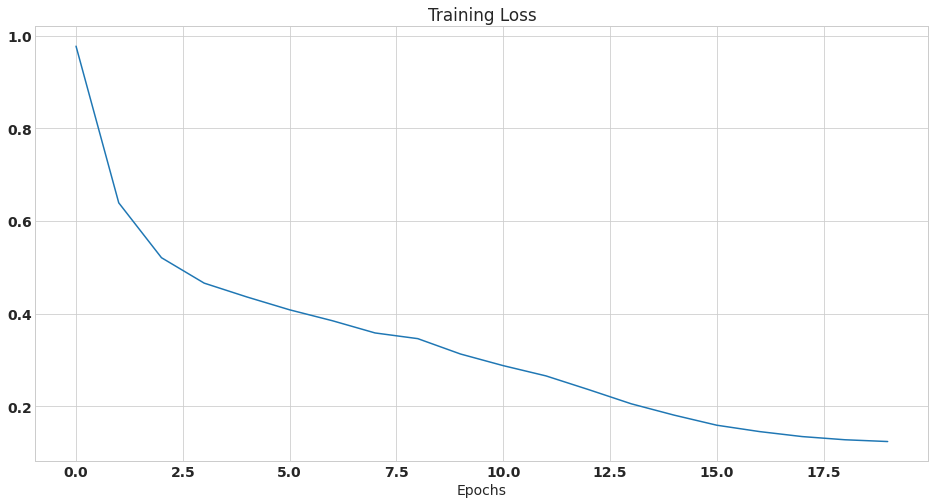

In [1859]:
# Plot training loss

plot_series(
    x=range(len(history_t2v.history['loss'])), 
    y=history_t2v.history['loss'], 
    title='Training Loss', 
    xlabel='Epochs'
    )

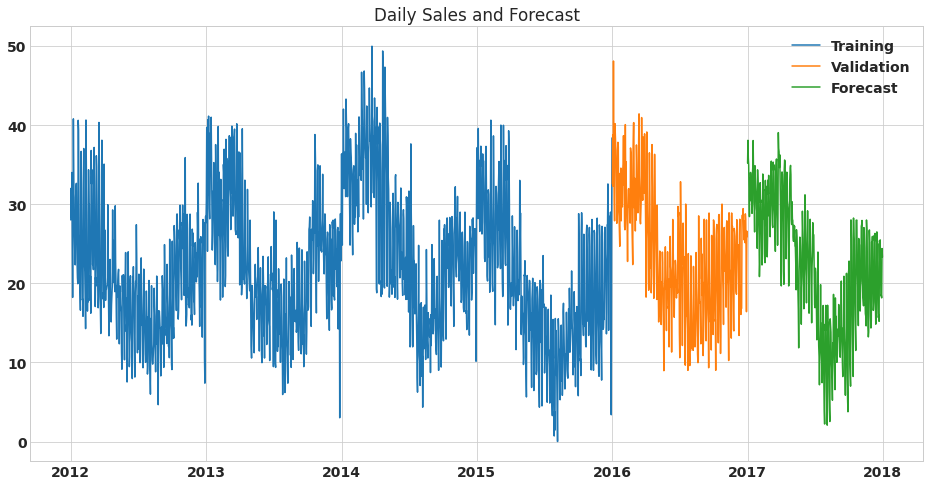

In [1860]:
# Plot whole series + forecast

forecast_t2v_df.index = forecast_dates.index
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_t2v_df.index, forecast_t2v_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

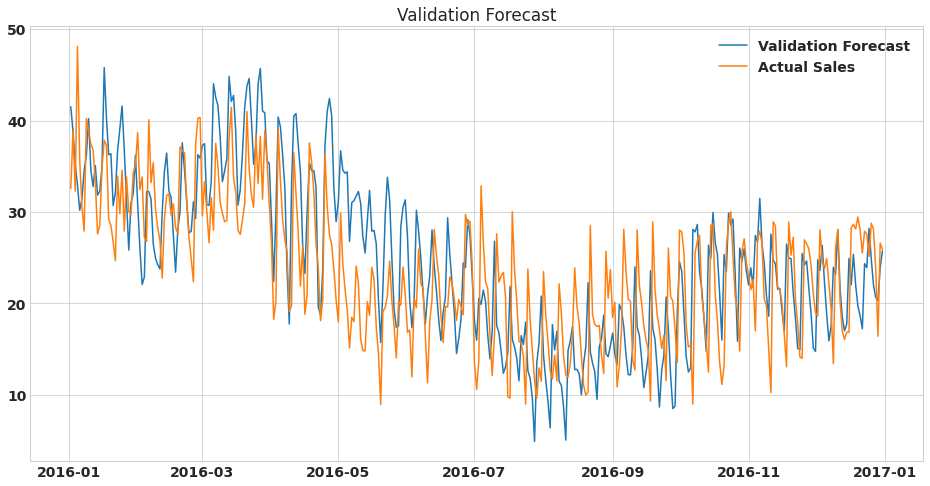

In [1861]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_t2v),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

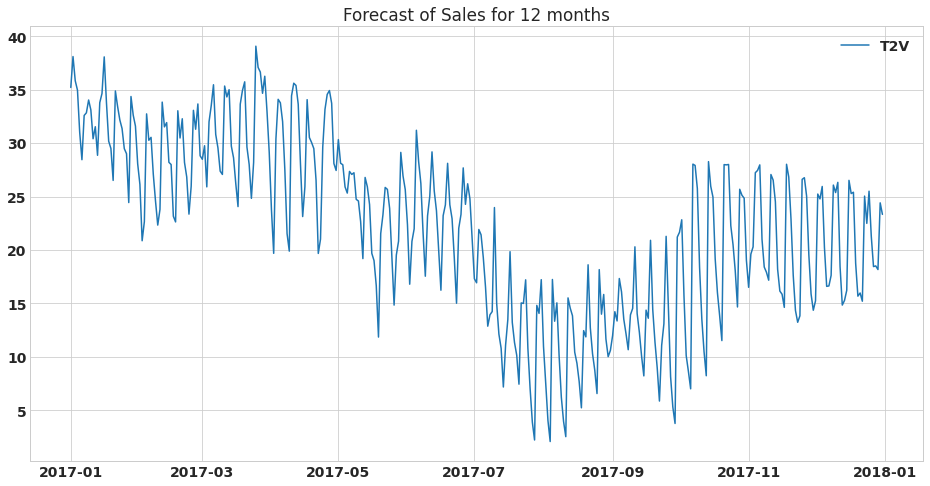

In [1862]:
# Forecast for 1 year ahead

plot_series(forecast_t2v_df.index, forecast_t2v_df, title='Forecast of Sales for 12 months', legend=['T2V'])

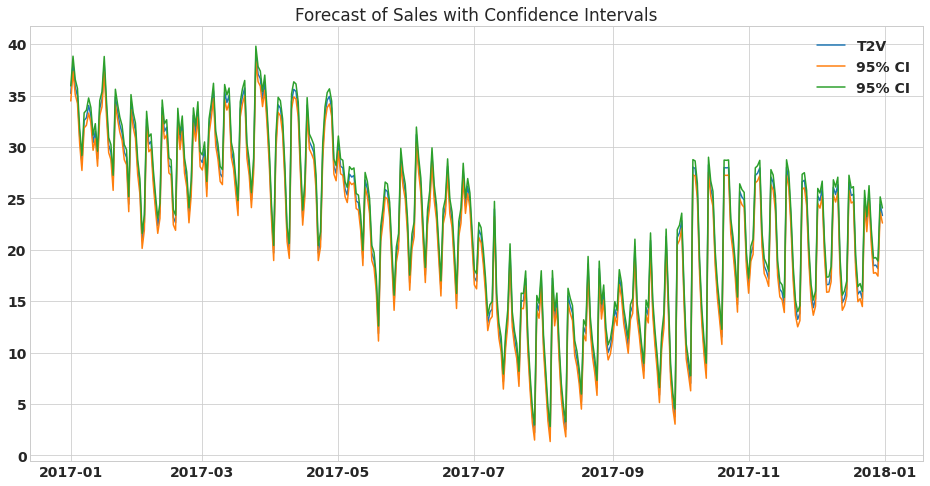

In [1863]:
# Forecast for 1 year ahead with confidence intervals

ci = 1.960*forecast_t2v_df.std(axis=0)/forecast_t2v_df.mean(axis=0)
ci_minus = [x - ci for x in forecast_t2v_df.values]
ci_plus = [x + ci for x in forecast_t2v_df.values]

plot_series(forecast_t2v_df.index, (forecast_t2v_df, ci_minus, ci_plus), legend=['T2V','95% CI','95% CI'], title='Forecast of Sales with Confidence Intervals')

## Ensemble Models

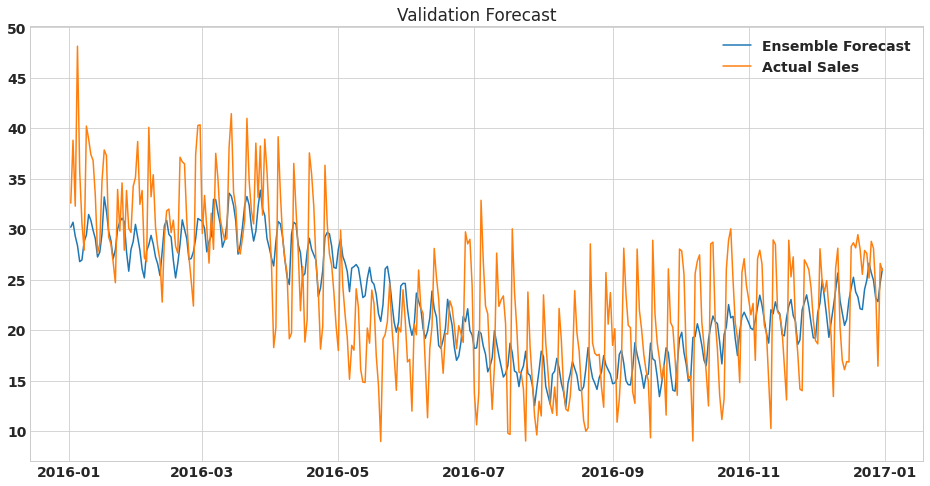

In [1864]:
# Plotting ensemble forecast for validation set

tv2preds = y_scaler_sequence.inverse_transform(pred_t2v)
grupreds = y_scaler_sequence.inverse_transform(pred_gru)
lstmpreds = y_scaler_sequence.inverse_transform(pred_lstm)
bilstmpreds = y_scaler_sequence.inverse_transform(pred_bilstm)        
ensemble_validation = (tv2preds + grupreds + lstmpreds + bilstmpreds) / 4

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (ensemble_validation , G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Ensemble Forecast', 'Actual Sales'])

In [1878]:
# Evaluating results

mse, mae = compute_metrics(y_true, ensemble_validation)
print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 5.256, mae: 4.272


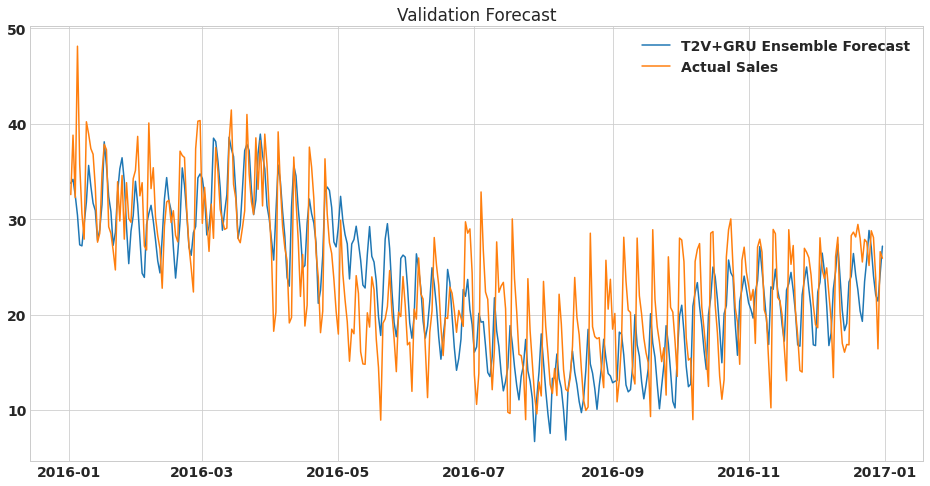

In [1866]:
# Plotting T2V+GRU ensemble forecast for validation set

t2vgru_validation = (tv2preds + grupreds) / 2
plot_series(G.TS.index[-G.FORECAST_HORIZON:], (t2vgru_validation , G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['T2V+GRU Ensemble Forecast', 'Actual Sales'])

In [1867]:
# Evaluating results

mse, mae = compute_metrics(y_true, t2vgru_validation)
print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 5.428, mae: 4.455


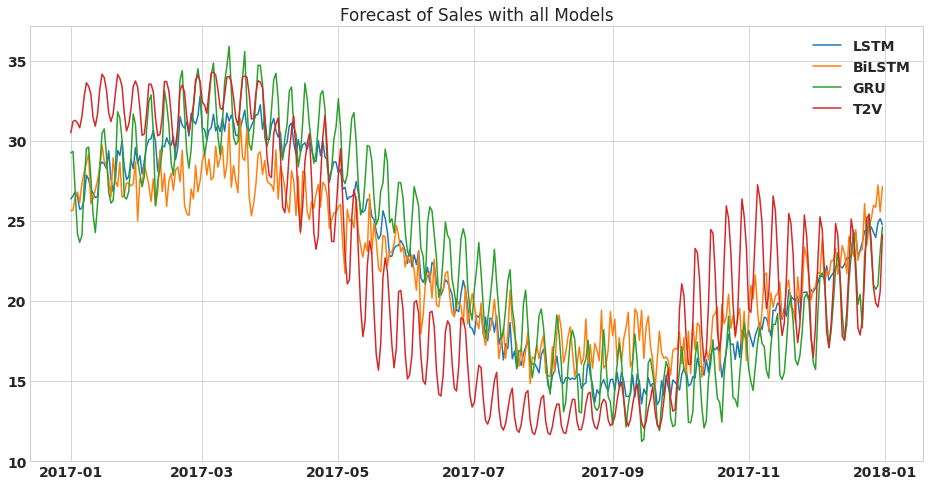

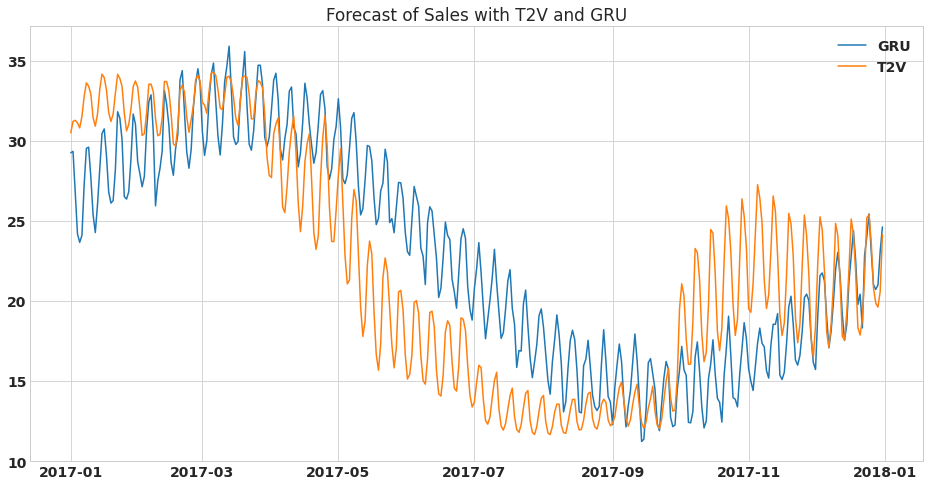

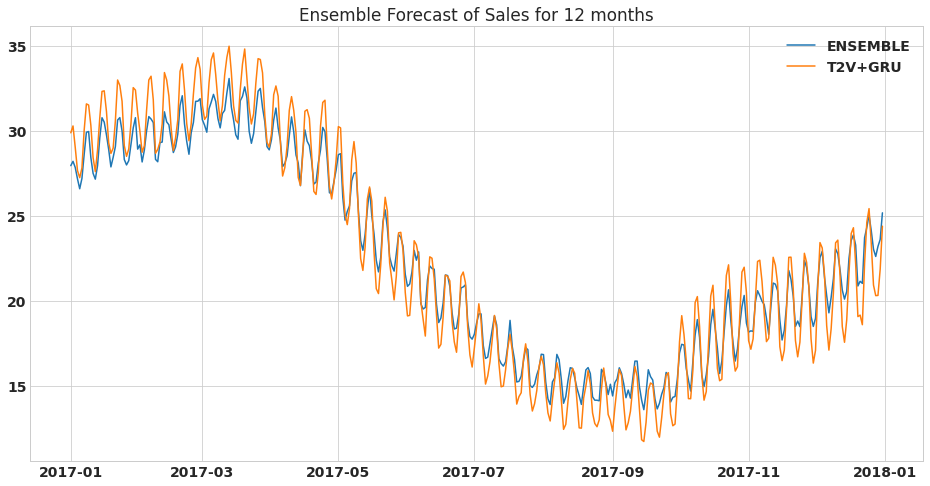

In [1868]:
# Forecast for 1 year ahead with all models and ensemble models


ensemble_forecast = (pred_forecast_lstm + pred_forecast_bilstm + pred_forecast_gru + pred_forecast_t2v) / 4
t2vgru_forecast = (pred_forecast_gru + pred_forecast_t2v) / 2
ensemble_forecast_std = ensemble_forecast.std(axis=0)
plot_series(pred_forecast.index, (pred_forecast_lstm, pred_forecast_bilstm, pred_forecast_gru, pred_forecast_t2v), legend=['LSTM','BiLSTM','GRU','T2V'], title='Forecast of Sales with all Models')
plot_series(pred_forecast.index, (pred_forecast_gru, pred_forecast_t2v), legend=['GRU', 'T2V'], title='Forecast of Sales with T2V and GRU')
plot_series(pred_forecast.index, (ensemble_forecast, t2vgru_forecast), legend=['ENSEMBLE', 'T2V+GRU'], title='Ensemble Forecast of Sales for 12 months')


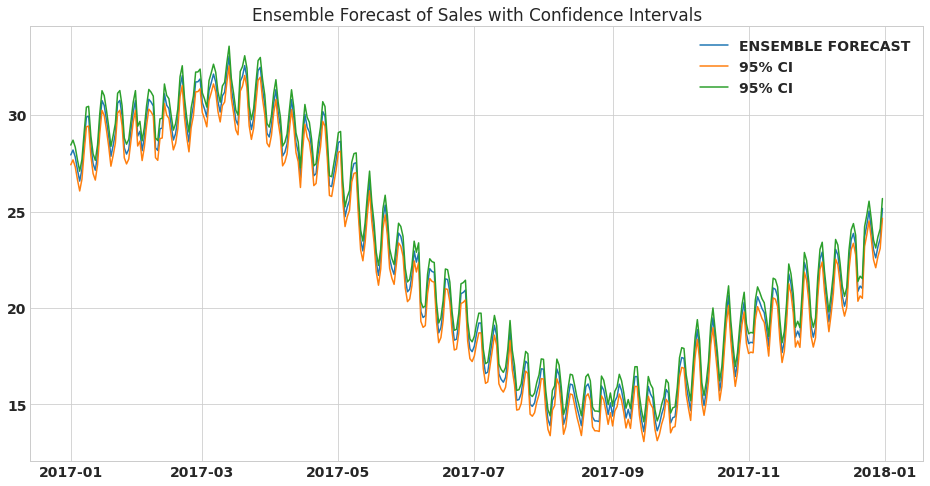

In [1869]:
# Plotting ensemble forecast with 95 % confidence intervals

ci = 1.960*ensemble_forecast.std(axis=0)/ensemble_forecast.mean(axis=0)
ci_minus = [x - ci for x in ensemble_forecast['Y_PRED'].values]
ci_plus = [x + ci for x in ensemble_forecast['Y_PRED'].values]

plot_series(pred_forecast.index, (ensemble_forecast['Y_PRED'], ci_minus, ci_plus), legend=['ENSEMBLE FORECAST','95% CI','95% CI'], title='Ensemble Forecast of Sales with Confidence Intervals')

# Conclusions

In [1870]:
# LSTM rmse: 6.389, mae: 5.238
# BILSTM rmse: 6.049, mae: 4.877
# GRU rrmse: 5.733, mae: 4.666
# T2V rmse: 6.727, mae: 5.513
# Ensemble rmse: rmse: 5.256, mae: 4.272
# Ensemble tv2+gru rmse: 5.428, mae: 4.455